# Imports

In [ ]:
!pip install datasets pandas torch transformers ml_things

In [ ]:
from datasets import load_dataset
import pandas as pd
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          GPT2LMHeadModel,
                          AutoTokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          PreTrainedTokenizer)
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from ml_things import plot_dict, plot_confusion_matrix, fix_text
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Evaluation
(adaptem from https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/)
## Model and training variables

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = '/content/drive/My Drive/SNLP Group Project/SS_final_datasets/trained_model_rephrasing_4_epochs/' # path for pretrained model, 'gpt2' for baseline
set_seed(14)
epochs = 4
batch_size = 8

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Helper functions

Data collator: transforms input text into tensors

In [ ]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_sequence_len=None):
        self.tokenizer = tokenizer
        self.max_sequence_len = tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

    def __call__(self, sequences):
        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels': torch.tensor(labels)})

        return inputs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training procedure for one epcoh

In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
  global model

  predictions_labels = []
  true_labels = []
  total_loss = 0

  model.train()

  for batch in tqdm(dataloader, total=len(dataloader), position=0, leave=True):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    model.zero_grad()
    outputs = model(**batch)

    loss, logits = outputs[:2]
    total_loss += loss.item()

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_.step()
    scheduler_.step()

    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Validation procedure for one epoch

In [ ]:
def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0

  model.eval()

  for batch in tqdm(dataloader, total=len(dataloader), position=0, leave=True):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Climate Detection dataset (CD)
https://huggingface.co/datasets/climatebert/climate_detection

In [ ]:
  dataset_path = 'climatebert/climate_detection'
  split = ['train', 'test']
  target_names = ['NO', 'YES']
  n_labels = 2
  max_length = 300

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load dataset

In [ ]:
train_dataset, test_dataset = load_dataset(dataset_path, split=split)
split_train = train_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=14)
train_dataset = split_train['train']
val_dataset = split_train['test']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Load pretrained model

In [ ]:
# Get model configuration.
print('Loading configuration...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')

tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuration...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/SNLP Group Project/SS_final_datasets/trained_model_rephrasing_4_epochs/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## Create dataloaders

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                          max_sequence_len=max_length)
# Train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!\n'%len(train_dataloader))

# Validation dataloader.
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!\n'%len(val_dataloader))

# Test dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!\n'%len(test_dataloader))

Created `train_dataloader` with 130 batches!

Created `eval_dataloader` with 33 batches!

Created `eval_dataloader` with 50 batches!



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluate model w/o downstream task finetuning

In [ ]:
# Get prediction form model on test data.
print('Test...')
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
test_f1 = f1_score(test_labels, test_predict)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test...


100%|██████████| 50/50 [00:02<00:00, 17.37it/s]


In [ ]:
print(classification_report(test_labels, test_predict, target_names=target_names))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

          NO       0.20      0.62      0.31        80
         YES       0.81      0.39      0.53       320

    accuracy                           0.44       400
   macro avg       0.51      0.51      0.42       400
weighted avg       0.69      0.44      0.48       400



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


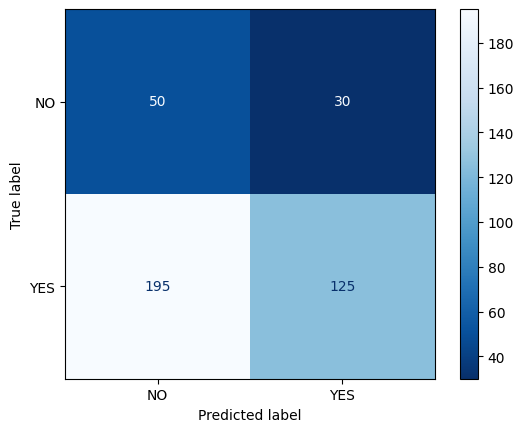

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                               test_predict,
                                               labels=range(len(target_names)),
                                               display_labels=target_names,
                                               cmap='Blues_r')
plt.grid(False)

## Finetune model on downstream task

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


100%|██████████| 130/130 [00:10<00:00, 12.66it/s]


Validation on batches...


 25%|██▌       | 1/4 [00:11<00:33, 11.22s/it]

  train_loss: 0.59064 - val_loss: 0.60984 - train_acc: 0.75865 - valid_acc: 0.76923 - train_f1: 0.86231 - valid_f1: 0.86957


Training on batches...


100%|██████████| 130/130 [00:09<00:00, 13.26it/s]


Validation on batches...


 50%|█████     | 2/4 [00:21<00:21, 10.92s/it]

  train_loss: 0.54872 - val_loss: 0.54116 - train_acc: 0.76923 - valid_acc: 0.76923 - train_f1: 0.86957 - valid_f1: 0.86957


Training on batches...


100%|██████████| 130/130 [00:09<00:00, 13.23it/s]


Validation on batches...


 75%|███████▌  | 3/4 [00:32<00:10, 10.83s/it]

  train_loss: 0.40677 - val_loss: 0.27812 - train_acc: 0.80769 - valid_acc: 0.89231 - train_f1: 0.88124 - valid_f1: 0.92857


Training on batches...


100%|██████████| 130/130 [00:09<00:00, 13.12it/s]


Validation on batches...


100%|██████████| 4/4 [00:43<00:00, 10.87s/it]
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


  train_loss: 0.21625 - val_loss: 0.30837 - train_acc: 0.92596 - valid_acc: 0.90385 - train_f1: 0.95154 - valid_f1: 0.93827



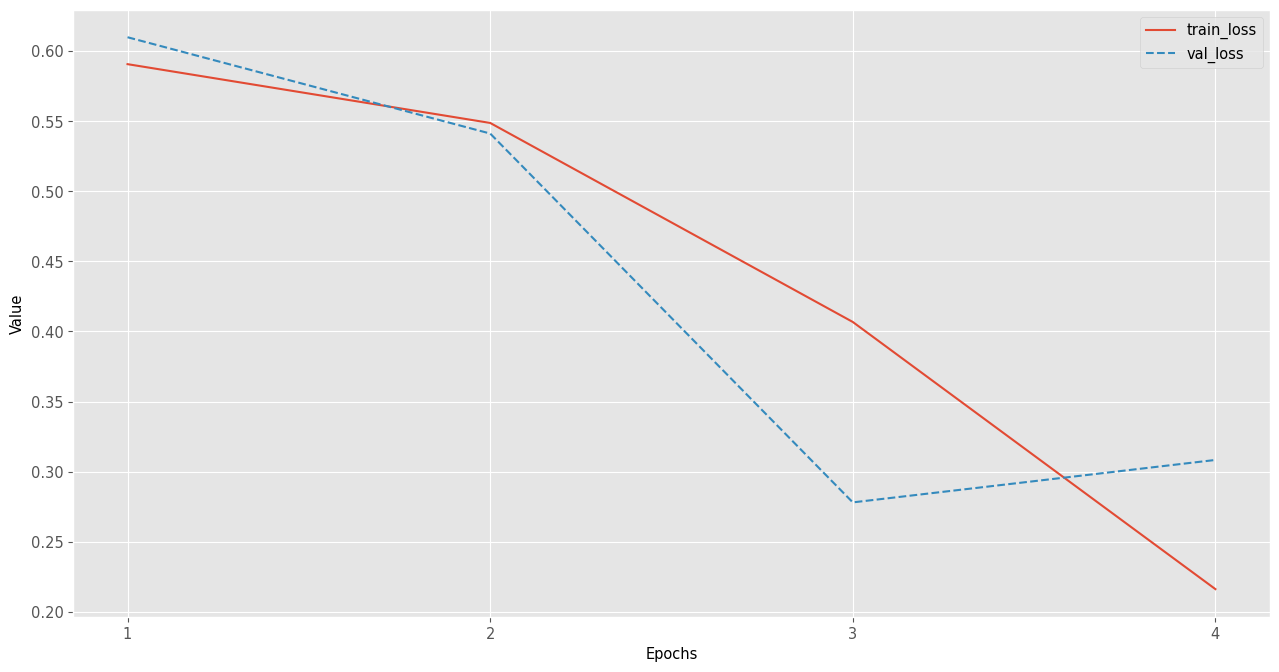

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


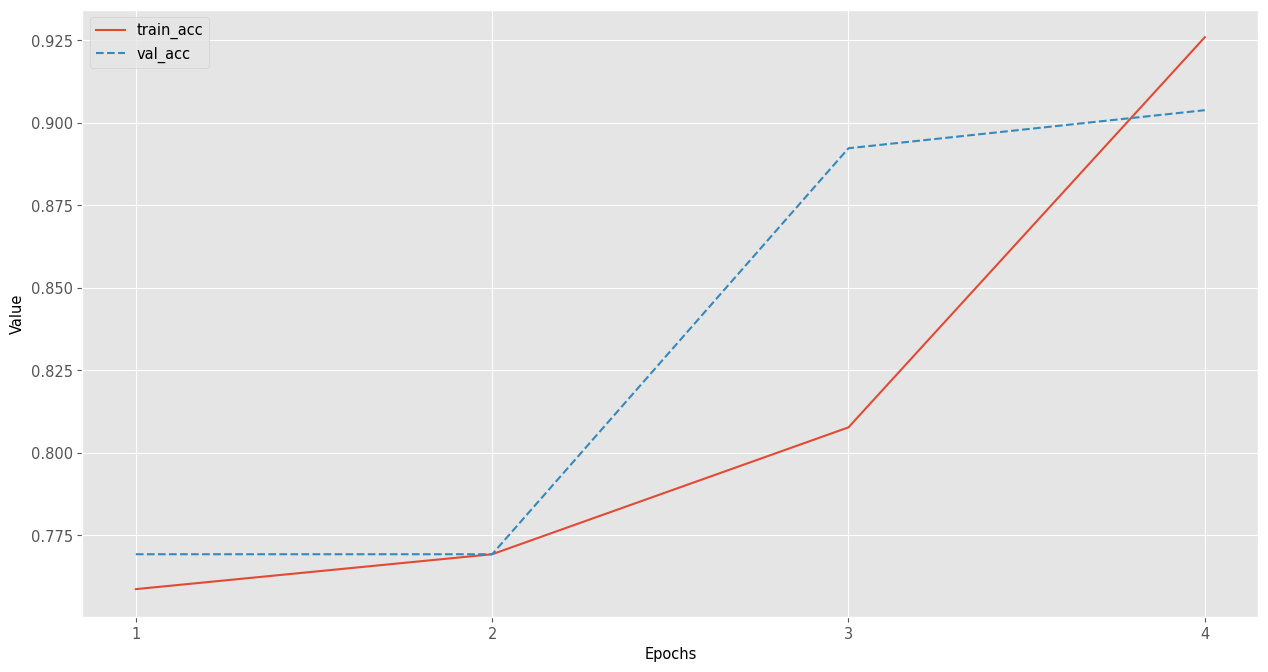

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


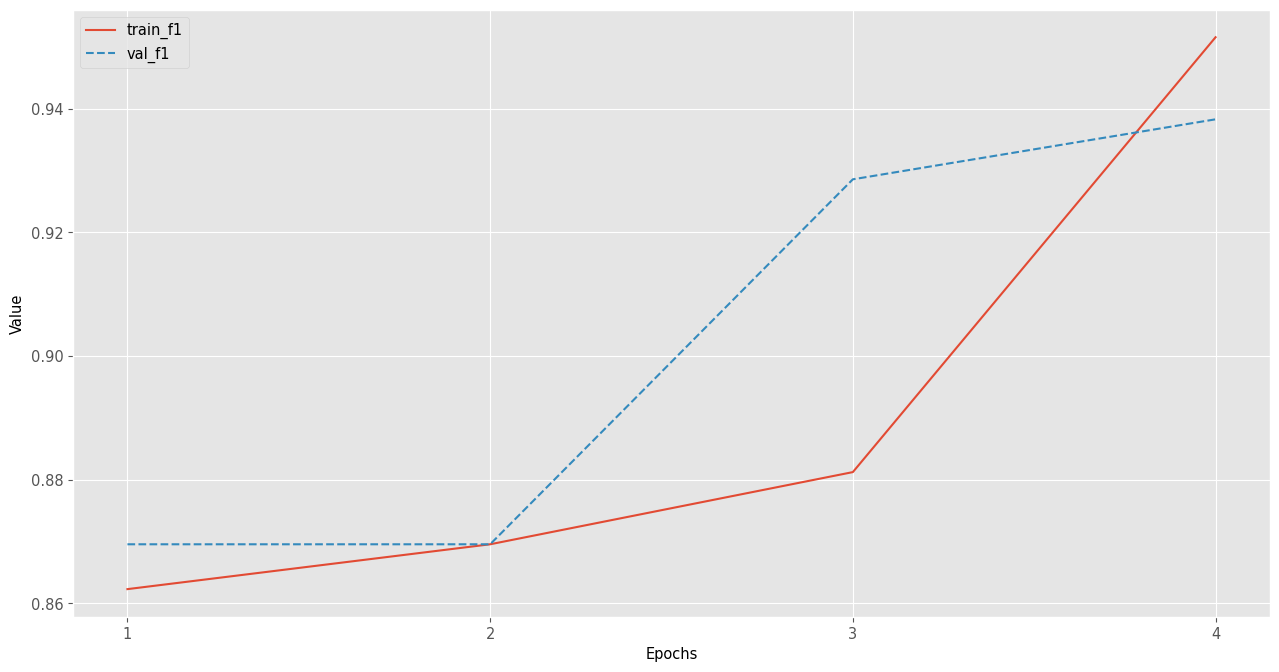

In [ ]:
optimizer = AdamW(model.parameters())

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
all_f1 = {'train_f1':[], 'val_f1':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  train_f1 = f1_score(train_labels, train_predict)

  print('Validation on batches...')
  val_labels, val_predict, val_loss = validation(val_dataloader, device)
  val_acc = accuracy_score(val_labels, val_predict)
  val_f1 = f1_score(val_labels, val_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f - train_f1: %.5f - valid_f1: %.5f"%(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)
  all_f1['train_f1'].append(train_f1)
  all_f1['val_f1'].append(val_f1)

plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_f1, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## Evaluate model w downstream task finetuning

In [ ]:
print('Test...')
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
test_f1 = f1_score(test_labels, test_predict)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test...


100%|██████████| 50/50 [00:01<00:00, 34.89it/s]


In [ ]:
print(classification_report(test_labels, test_predict, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.74      0.78      0.76        80
         YES       0.94      0.93      0.94       320

    accuracy                           0.90       400
   macro avg       0.84      0.85      0.85       400
weighted avg       0.90      0.90      0.90       400



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


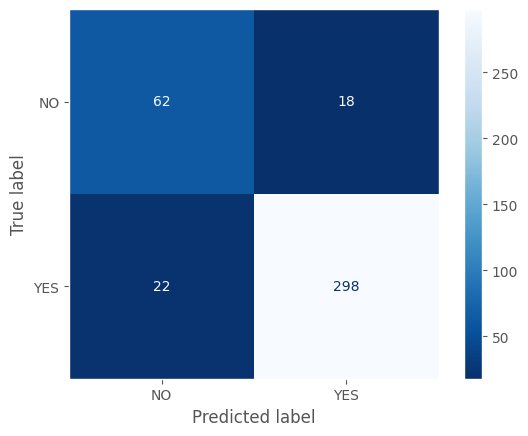

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                               test_predict,
                                               labels=range(len(target_names)),
                                               display_labels=target_names,
                                               cmap='Blues_r')
plt.grid(False)

# Environmental claims dataset (EC)
https://huggingface.co/datasets/climatebert/environmental_claims

In [ ]:
  dataset_path = 'climatebert/environmental_claims'
  split = ['train', 'validation', 'test']
  target_names = ['NO', 'YES']
  n_labels = 2
  max_length = 78

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load dataset

In [ ]:
train_dataset, val_dataset, test_dataset = load_dataset(dataset_path, split=split)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load model

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/SNLP Group Project/SS_final_datasets/trained_model_rephrasing_4_epochs/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## Create dataloaders

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                          max_sequence_len=max_length)
# Train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!\n'%len(train_dataloader))

# Validation dataloader.
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!\n'%len(val_dataloader))

# Test dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!\n'%len(test_dataloader))

Created `train_dataloader` with 265 batches!

Created `eval_dataloader` with 34 batches!

Created `eval_dataloader` with 34 batches!



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluate model w/o downstream task finetuning

In [ ]:
# Get prediction form model on test data.
print('Test...')
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
test_f1 = f1_score(test_labels, test_predict)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test...


100%|██████████| 34/34 [00:00<00:00, 60.14it/s]


In [ ]:
print(classification_report(test_labels, test_predict, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.74      0.92      0.82       198
         YES       0.11      0.03      0.05        67

    accuracy                           0.69       265
   macro avg       0.42      0.47      0.43       265
weighted avg       0.58      0.69      0.62       265



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


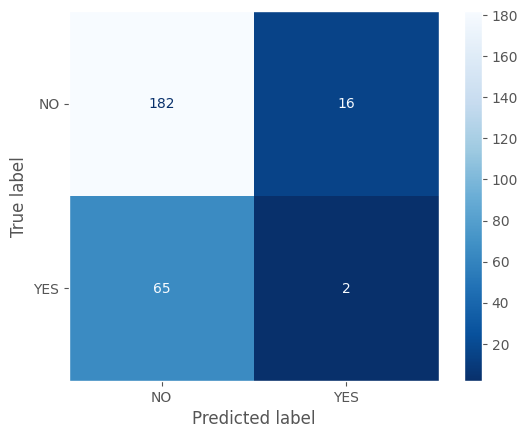

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                               test_predict,
                                               labels=range(len(target_names)),
                                               display_labels=target_names,
                                               cmap='Blues_r')
plt.grid(False)

## Finetune model on downstream task

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


100%|██████████| 265/265 [00:12<00:00, 21.96it/s]


Validation on batches...


 25%|██▌       | 1/4 [00:12<00:37, 12.58s/it]

  train_loss: 0.38282 - val_loss: 0.29413 - train_acc: 0.83892 - valid_acc: 0.88679 - train_f1: 0.64954 - valid_f1: 0.78261


Training on batches...


100%|██████████| 265/265 [00:11<00:00, 22.84it/s]


Validation on batches...


 50%|█████     | 2/4 [00:24<00:24, 12.29s/it]

  train_loss: 0.17765 - val_loss: 0.35166 - train_acc: 0.93198 - valid_acc: 0.89057 - train_f1: 0.86180 - valid_f1: 0.78195


Training on batches...


100%|██████████| 265/265 [00:11<00:00, 22.86it/s]


Validation on batches...


 75%|███████▌  | 3/4 [00:36<00:12, 12.19s/it]

  train_loss: 0.05891 - val_loss: 0.55345 - train_acc: 0.97780 - valid_acc: 0.87547 - train_f1: 0.95595 - valid_f1: 0.76923


Training on batches...


100%|██████████| 265/265 [00:11<00:00, 22.84it/s]


Validation on batches...


100%|██████████| 4/4 [00:48<00:00, 12.21s/it]
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


  train_loss: 0.00660 - val_loss: 0.66024 - train_acc: 0.99811 - valid_acc: 0.86792 - train_f1: 0.99624 - valid_f1: 0.75524



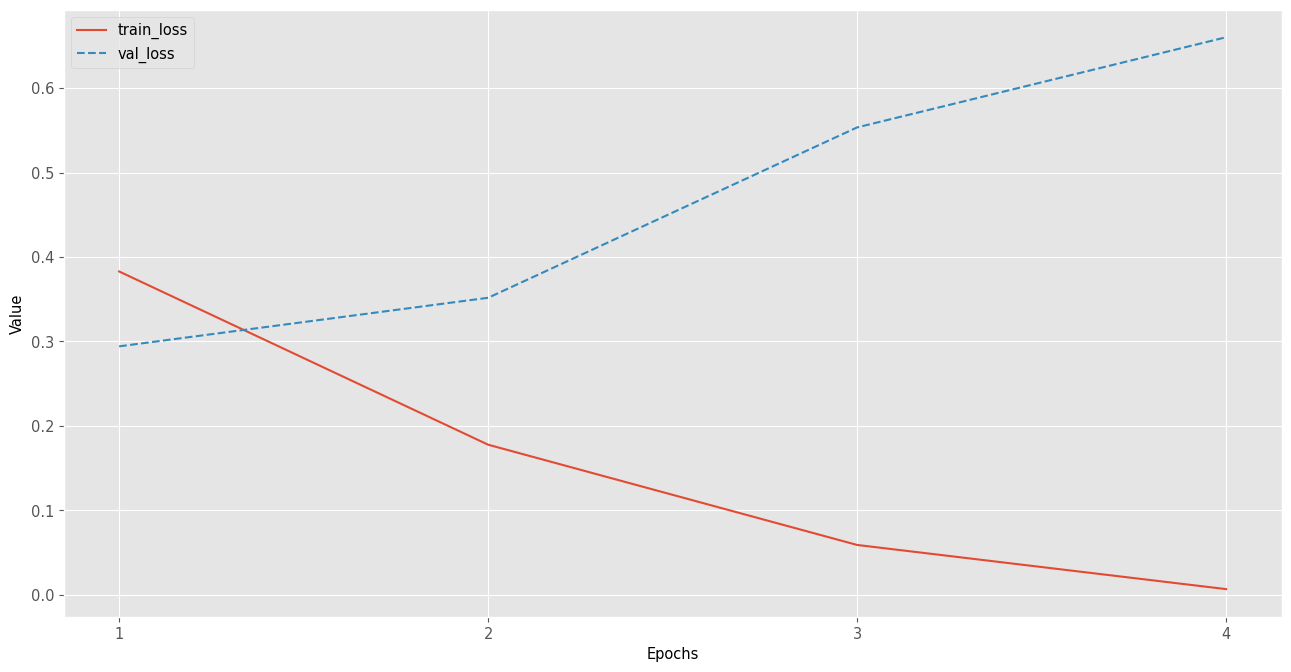

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


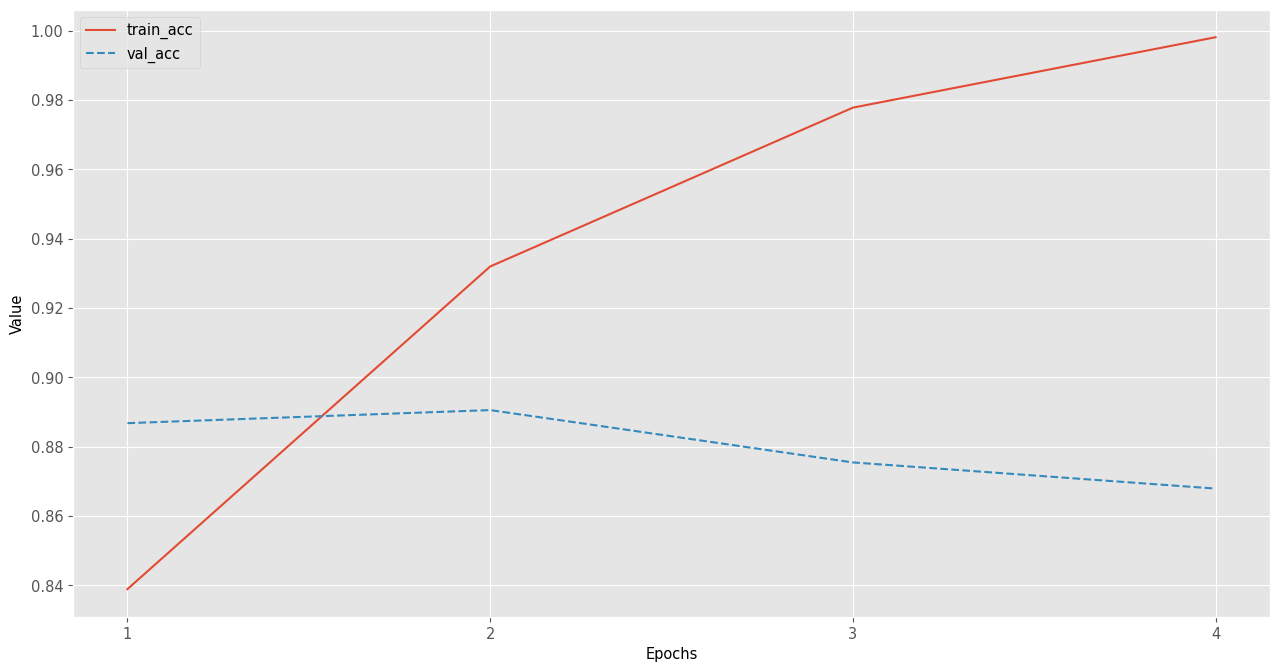

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


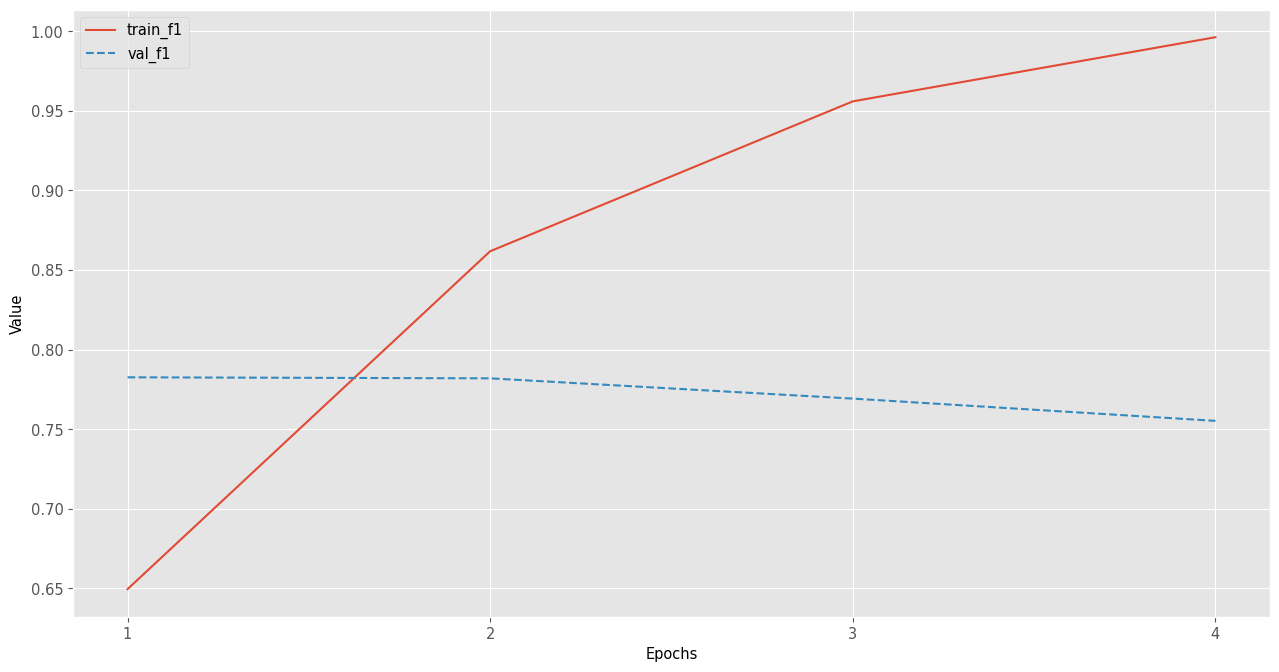

In [ ]:
optimizer = AdamW(model.parameters())

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
all_f1 = {'train_f1':[], 'val_f1':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  train_f1 = f1_score(train_labels, train_predict)

  print('Validation on batches...')
  val_labels, val_predict, val_loss = validation(val_dataloader, device)
  val_acc = accuracy_score(val_labels, val_predict)
  val_f1 = f1_score(val_labels, val_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f - train_f1: %.5f - valid_f1: %.5f"%(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)
  all_f1['train_f1'].append(train_f1)
  all_f1['val_f1'].append(val_f1)

plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_f1, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## Evaluate model w downstream task finetuning

In [ ]:
# Get prediction from model on test data.
print('Test...')
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
test_f1 = f1_score(test_labels, test_predict)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test...


100%|██████████| 34/34 [00:00<00:00, 74.07it/s]


In [ ]:
print(classification_report(test_labels, test_predict, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.94      0.92      0.93       198
         YES       0.77      0.82      0.80        67

    accuracy                           0.89       265
   macro avg       0.86      0.87      0.86       265
weighted avg       0.90      0.89      0.90       265



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


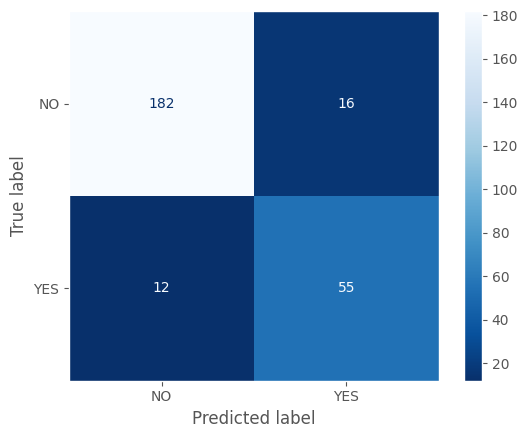

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                               test_predict,
                                               labels=range(len(target_names)),
                                               display_labels=target_names,
                                               cmap='Blues_r')
plt.grid(False)

# Climate sentiment dataset (CS)
https://huggingface.co/datasets/climatebert/climate_sentiment

In [ ]:
  dataset_path = 'climatebert/climate_sentiment'
  split = ['train', 'test']
  target_names = ['RISK', 'NEUTRAL', 'OPPORTUNITY']
  n_labels = 3
  max_length = 300

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load dataset

In [ ]:
train_dataset, test_dataset = load_dataset(dataset_path, split=split)
split_train = train_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=14)
train_dataset = split_train['train']
val_dataset = split_train['test']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load model

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/SNLP Group Project/SS_final_datasets/trained_model_rephrasing_4_epochs/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## Create dataloaders

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                          max_sequence_len=max_length)
# Train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!\n'%len(train_dataloader))

# Validation dataloader.
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!\n'%len(val_dataloader))

# Test dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!\n'%len(test_dataloader))

Created `train_dataloader` with 100 batches!

Created `eval_dataloader` with 25 batches!

Created `eval_dataloader` with 40 batches!



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluate model w/o downstream task finetuning

In [ ]:
# Get prediction form model on test data.
print('Test...')
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
test_f1 = f1_score(test_labels, test_predict, average='weighted')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test...


100%|██████████| 40/40 [00:01<00:00, 29.46it/s]


In [ ]:
print(classification_report(test_labels, test_predict, target_names=target_names))

              precision    recall  f1-score   support

        RISK       0.50      0.02      0.04       106
     NEUTRAL       0.84      0.13      0.22       163
 OPPORTUNITY       0.16      0.92      0.27        51

    accuracy                           0.22       320
   macro avg       0.50      0.36      0.18       320
weighted avg       0.62      0.22      0.17       320



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


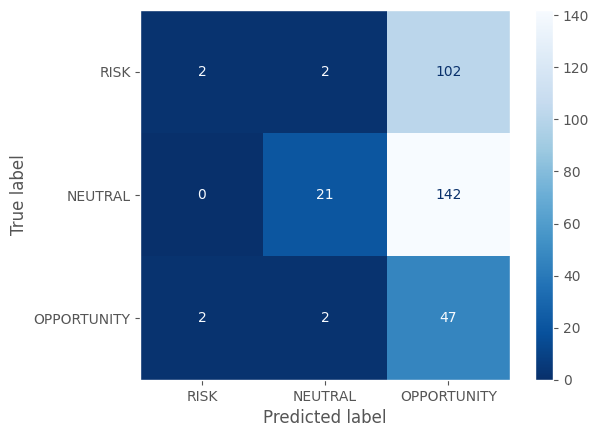

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                               test_predict,
                                               labels=range(len(target_names)),
                                               display_labels=target_names,
                                               cmap='Blues_r')
plt.grid(False)

## Finetune model on downstream task

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


Validation on batches...


 25%|██▌       | 1/4 [00:08<00:25,  8.42s/it]

  train_loss: 0.81334 - val_loss: 0.46190 - train_acc: 0.59250 - valid_acc: 0.80500 - train_f1: 0.59215 - valid_f1: 0.80553


Training on batches...


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Validation on batches...


 50%|█████     | 2/4 [00:16<00:16,  8.33s/it]

  train_loss: 0.37357 - val_loss: 0.48935 - train_acc: 0.84500 - valid_acc: 0.80500 - train_f1: 0.84500 - valid_f1: 0.80613


Training on batches...


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Validation on batches...


 75%|███████▌  | 3/4 [00:24<00:08,  8.29s/it]

  train_loss: 0.11353 - val_loss: 0.88792 - train_acc: 0.95625 - valid_acc: 0.78500 - train_f1: 0.95627 - valid_f1: 0.78390


Training on batches...


100%|██████████| 100/100 [00:07<00:00, 13.22it/s]


Validation on batches...


100%|██████████| 4/4 [00:33<00:00,  8.29s/it]
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


  train_loss: 0.03080 - val_loss: 1.02408 - train_acc: 0.98750 - valid_acc: 0.81000 - train_f1: 0.98750 - valid_f1: 0.81021



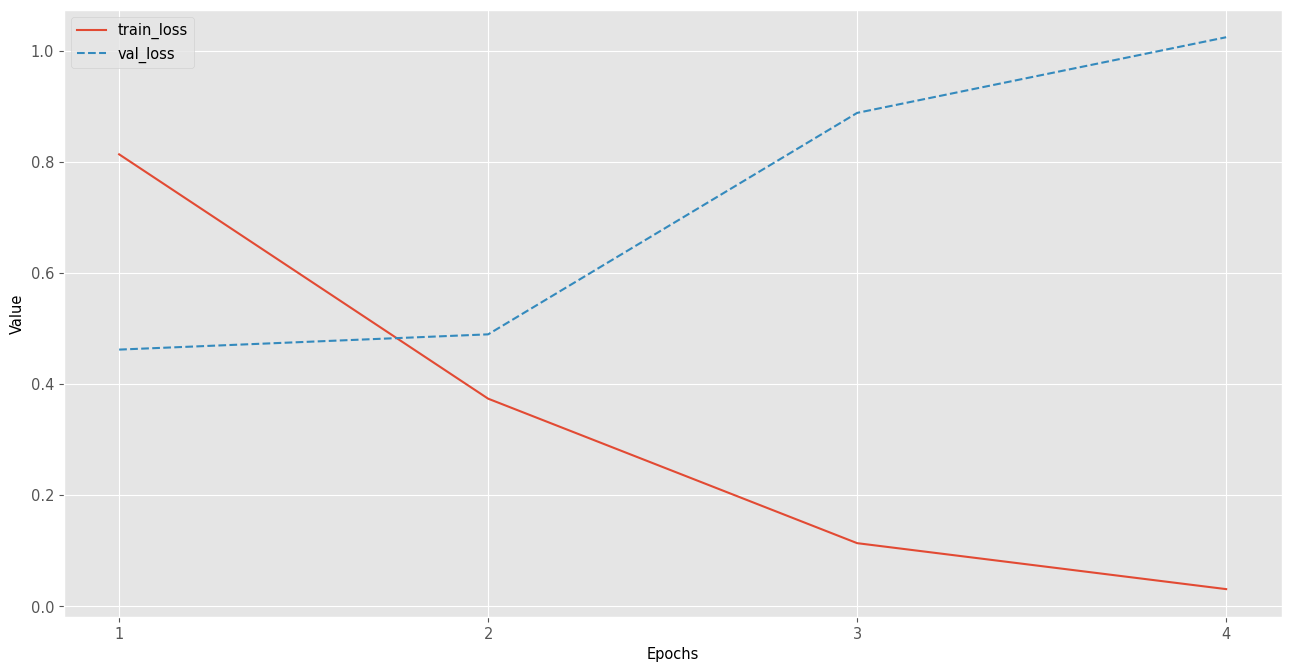

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


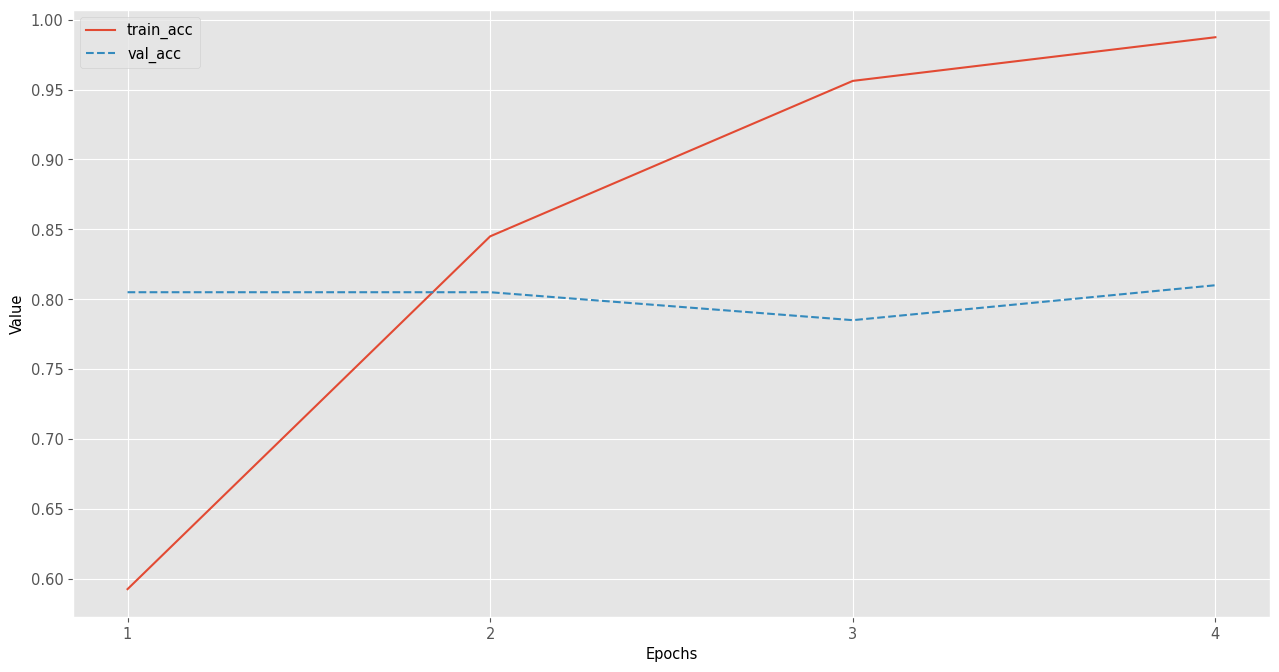

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


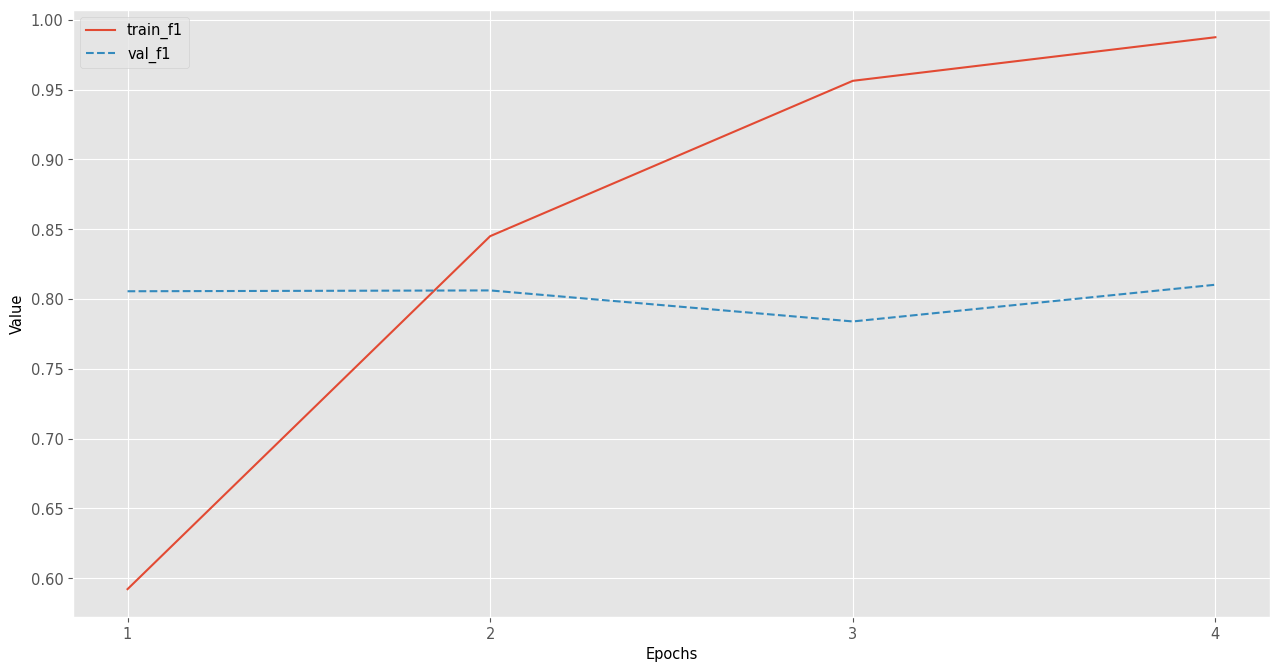

In [ ]:
optimizer = AdamW(model.parameters())

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
all_f1 = {'train_f1':[], 'val_f1':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  train_f1 = f1_score(train_labels, train_predict, average='weighted')

  print('Validation on batches...')
  val_labels, val_predict, val_loss = validation(val_dataloader, device)
  val_acc = accuracy_score(val_labels, val_predict)
  val_f1 = f1_score(val_labels, val_predict, average='weighted')

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f - train_f1: %.5f - valid_f1: %.5f"%(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)
  all_f1['train_f1'].append(train_f1)
  all_f1['val_f1'].append(val_f1)

plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_f1, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## Evaluate model w downstream task finetuning

In [ ]:
# Get prediction from model on test data.
print('Test...')
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
test_f1 = f1_score(test_labels, test_predict, average='weighted')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test...


100%|██████████| 40/40 [00:01<00:00, 34.90it/s]


In [ ]:
print(classification_report(test_labels, test_predict, target_names=target_names))

              precision    recall  f1-score   support

        RISK       0.82      0.83      0.83       106
     NEUTRAL       0.79      0.74      0.76       163
 OPPORTUNITY       0.52      0.63      0.57        51

    accuracy                           0.75       320
   macro avg       0.71      0.73      0.72       320
weighted avg       0.76      0.75      0.75       320



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


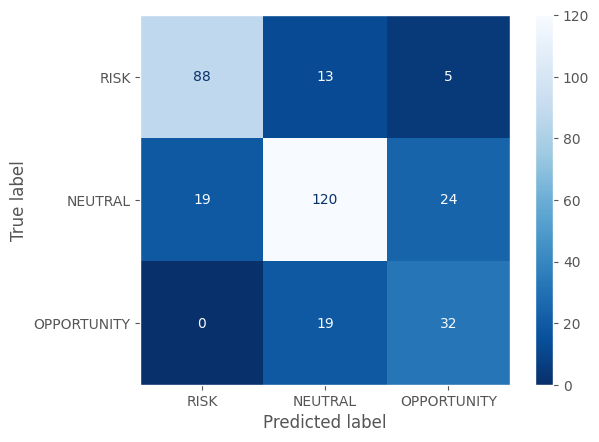

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,
                                               test_predict,
                                               labels=range(len(target_names)),
                                               display_labels=target_names,
                                               cmap='Blues_r')
plt.grid(False)